<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/ThreeOrSeven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 15.8 MB/s 
     |████████████████████████████████| 4.2 MB 55.7 MB/s 
     |████████████████████████████████| 197 kB 45.5 MB/s 
     |████████████████████████████████| 346 kB 30.8 MB/s 
     |████████████████████████████████| 1.2 MB 18.6 MB/s 
     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 140 kB 57.5 MB/s 
     |████████████████████████████████| 1.1 MB 58.0 MB/s 
     |████████████████████████████████| 212 kB 74.7 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 127 kB 63.4 MB/s 
     |████████████████████████████████| 271 kB 70.9 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 76.4 MB/s 
     |████████████████████████████████| 596 kB 60.0 MB/s 
     |████████████████████████████████| 6.6 MB 64.8 MB/s 
ERROR: pip's dependenc

In [2]:
#Load in images of 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)
#List things in the path
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [3]:
#Get image paths for 3s and 7s
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [4]:
#Show image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [5]:
#Image data can be represented in arrays
#Here is our image in a numpy array - showing rows and cols 4 through 10
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [6]:
#And now as a PyTorch Tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [7]:
#Use pandas to color code the values, giving us a better representation
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [8]:
#Store all image in tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

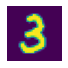

In [9]:
#use fastai show_image to display image in tensor
show_image(three_tensors[92])

In [10]:
#Our initial approach we are going to get average of all pixels
#To do this we will stack all images of each number into a single tensor
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

#Size gives us the length of each axis in a tensor
#Here we have count, pixels width, pixels height
stacked_threes.shape

torch.Size([6131, 28, 28])

In [11]:
#The length of the shape is a tensor's rank
len(stacked_threes.shape)

3

In [12]:
#Rank can also be accessed with ndim
stacked_threes.ndim 

3

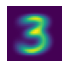

In [13]:
#To get the average of all images we call the mean method on dim 0 of stack
mean3 = stacked_threes.mean(0)
show_image(mean3)

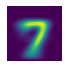

In [14]:
#Now for our set of 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [15]:
#We can test to see how far a test image is from the avg 3 or avg 7
a_3 = stacked_threes[2] #Test img
#Get absloute val of pixel differences to avoid cancellation of "too light" and "too dark"
dist_3_abs = (a_3 - mean3).abs().mean() #dist to avg 3
dist_7_abs = (a_3 - mean7).abs().mean() #dist to avg 7
dist_3_abs, dist_7_abs #Dist to 3 is smaller, so model picks 3

(tensor(0.1100), tensor(0.1541))

In [16]:
#We can do a similar thing by squaring the differences (to get a positive) then taking the root
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() #to 3
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt() #to 7
dist_3_sqr, dist_7_sqr #again 3 is a better solution

(tensor(0.1980), tensor(0.2974))

In [17]:
#Pytorch already provides these as loss functions
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1541), tensor(0.2974))

In [18]:
#Create tensor objs for validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
#Change float to 0 to 1
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = valid_7_tens.float() / 255
#Print size
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [19]:
#Create func to determine distance of an image to a mean
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1100)

In [20]:
#Get dist of all images in validation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1373, 0.1638, 0.1190,  ..., 0.1331, 0.1224, 0.1778]),
 torch.Size([1010]))

In [21]:
#Func to determine 3 or 7
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)
#See if it works
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [22]:
#Thanks to broadcasting we can tet entire validation set
is_3(valid_3_tens)

tensor([False,  True,  True,  ...,  True,  True,  True])

In [23]:
#We can test the accuracy by getting the average of the bool vals
acc_3 = is_3(valid_3_tens).float().mean()
acc_7 = 1 - is_3(valid_7_tens).float().mean()
acc_3, acc_7

(tensor(0.9168), tensor(0.9854))

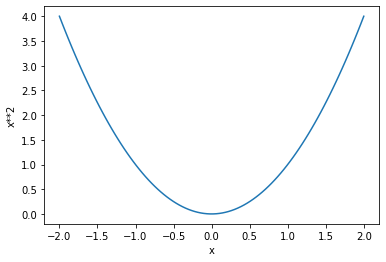

In [24]:
#Stocahastic Gradient Example
def f(x): return x**2
plot_function(f, 'x', 'x**2')

In [25]:
#Create tensor and tell it that we need gradients
xt = tensor(3.).requires_grad_()
#Calculate f(xt)
yt = f(xt)
yt #tensor obj that has gradient

tensor(9., grad_fn=<PowBackward0>)

In [26]:
#calculate gradient
yt.backward()
#We can now view the gradients
xt.grad

tensor(6.)

In [27]:
#we can do this on vectors as well
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [28]:
def f(x): return (x**2).sum() #add sum so we can handle vectors
yt = f(xt)
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## Below we will cover the learning rate, which is the coefficent we use to decide how far we move based on the gradient calculated

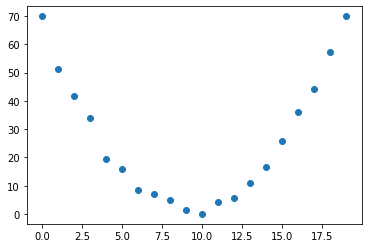

In [51]:
#Get some data
time = torch.arange(0,20).float()
speed = torch.randn(20)*3 + .75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [52]:
#separate time and parameters
#We restrict the best function to the best 'quadratic' function
def f(t, params):
  a, b, c = params
  return a*(t**2) + (b*t) + c

In [53]:
def mse(preds, targets): return ((preds-targets)**2).mean()

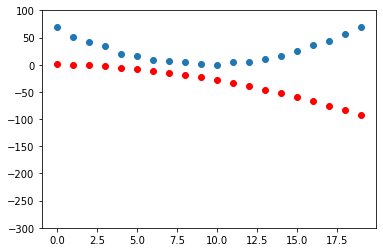

In [54]:
#Step 1: Initialize Parameters
params = torch.randn(3).requires_grad_()  #Random starting pos
#Step 2: Calculate Predictions
preds = f(time, params)
  #Show how good predictions are
def show_preds(preds, ax=None):
  if ax is None: ax = plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300,100)
show_preds(preds)

In [55]:
#Step 3: Calculate Loss
loss = mse(preds, speed)
loss

tensor(5246.0479, grad_fn=<MeanBackward0>)

In [56]:
#Step 4: Calculate Gradients
loss.backward()
params.grad

tensor([-22875.8320,  -1470.5222,   -118.8852])

In [57]:
#Step 5: Step the weights
lr = .00001
params.data -= lr * params.grad.data #Step
params.grad = None  #Clear gradients
#See if we improved
preds = f(time,params)
mse(preds,speed)

tensor(1475.7100, grad_fn=<MeanBackward0>)

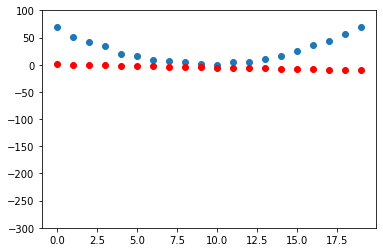

In [58]:
#Show in plot
show_preds(preds)

In [59]:
#Def above as func
def apply_step(params, prn=True):
  preds = f(time,params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

In [60]:
#Step 6: Repeat the process
for i in range(10): apply_step(params)

1475.7099609375
762.2440185546875
627.2316284179688
601.6802978515625
596.842529296875
595.9243774414062
595.7476806640625
595.7115478515625
595.701904296875
595.697265625


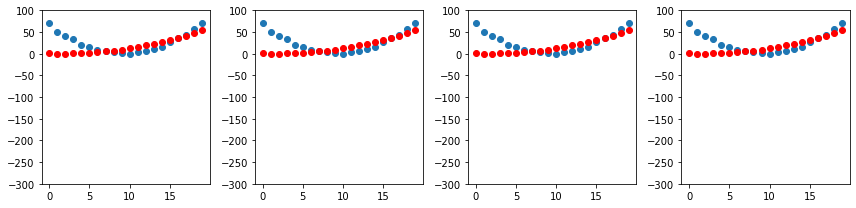

In [62]:
#Plot func at every step for better visual
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [ ]:
#Step 7: Stop
#In practice we'd watch the validation losses and metrics to determine a stopping parameter

## We now jump back into our 3s vs 7s example. In this section we will define a training objective

In [63]:
#Concatenate training data into list of vectors (rank 2)
#View can change shape withou changing contents, -1 means "make this axis as big as needed"
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

#Label each image, 1 for 3 and 0 for 7
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape #Make sure shapes match

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [65]:
#Dataset in PyTorch requires a return tuple of (x,y)
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [66]:
#Do same for validation data
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [67]:
#Generate random init weight for each pixel
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
bias = init_params(1)
#y = wx+b, w is weights b is bias

In [68]:
#Set up matrix multiplication using @ operator for fast iteration
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-0.5521],
        [-3.3493],
        [-5.9666],
        ...,
        [ 4.0908],
        [ 9.0340],
        [ 7.6712]], grad_fn=<AddBackward0>)

In [69]:
#Check our accuracy
corrects = (preds>0.0).float() == train_y #recall our labels are 0s and 1s so a match is a correct prediction
acc = corrects.float().mean().item()
acc

0.5101645588874817

In [71]:
"""We cant use acc as a loss func because small changes most likely wont change predictions
So our gradients would be 0 because old_acc = new_acc in that case
We can use confidience levels to help.

Let trgts be our labels and 3s = 1 and 7s = 0
Let prbs be our probability an image is a 3
    So .2 is pretty confident its a 7
    .9 is very confident its a 3
    .45 be not conmfident at all but pick 7

trgts = [1, 0, 1]
prbs = [.9, .45, .2]

then we can take our distances to each label and get an idea of our loss from the function below
"""

def mnist_loss(predictions, targets):
  predictions.sigmoid() #Just double check all our predictions are between 0 and 1
  return torch.where(targets==1, 1-predictions, predictions).mean() #1-preds when label 1, preds otherwise. Then get mean
